In [130]:
# Import Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Load the Housing Prices dataset

In [131]:
# Load the training and testing datasets
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [132]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [133]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Data Exploration

In [134]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [135]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [136]:
# Display summary statistics of the target variable 'SalePrice'
print(train_df['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


# Data Visualization

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/tmp/ipykernel_32/3643623601.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['SalePrice'], color='b', bins=100, hist_kws={'alpha': 0.4});


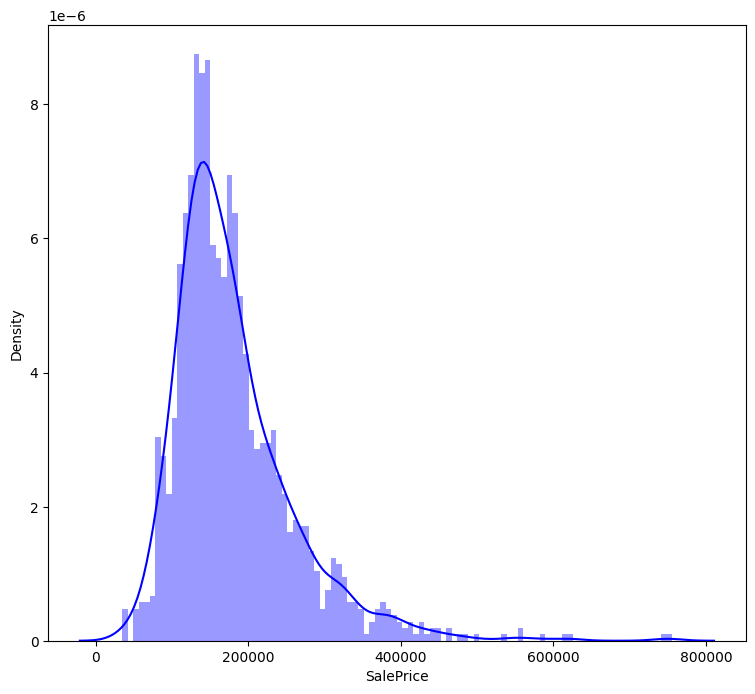

In [137]:
# Plot the distribution of 'SalePrice'
print(train_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_df['SalePrice'], color='b', bins=100, hist_kws={'alpha': 0.4});

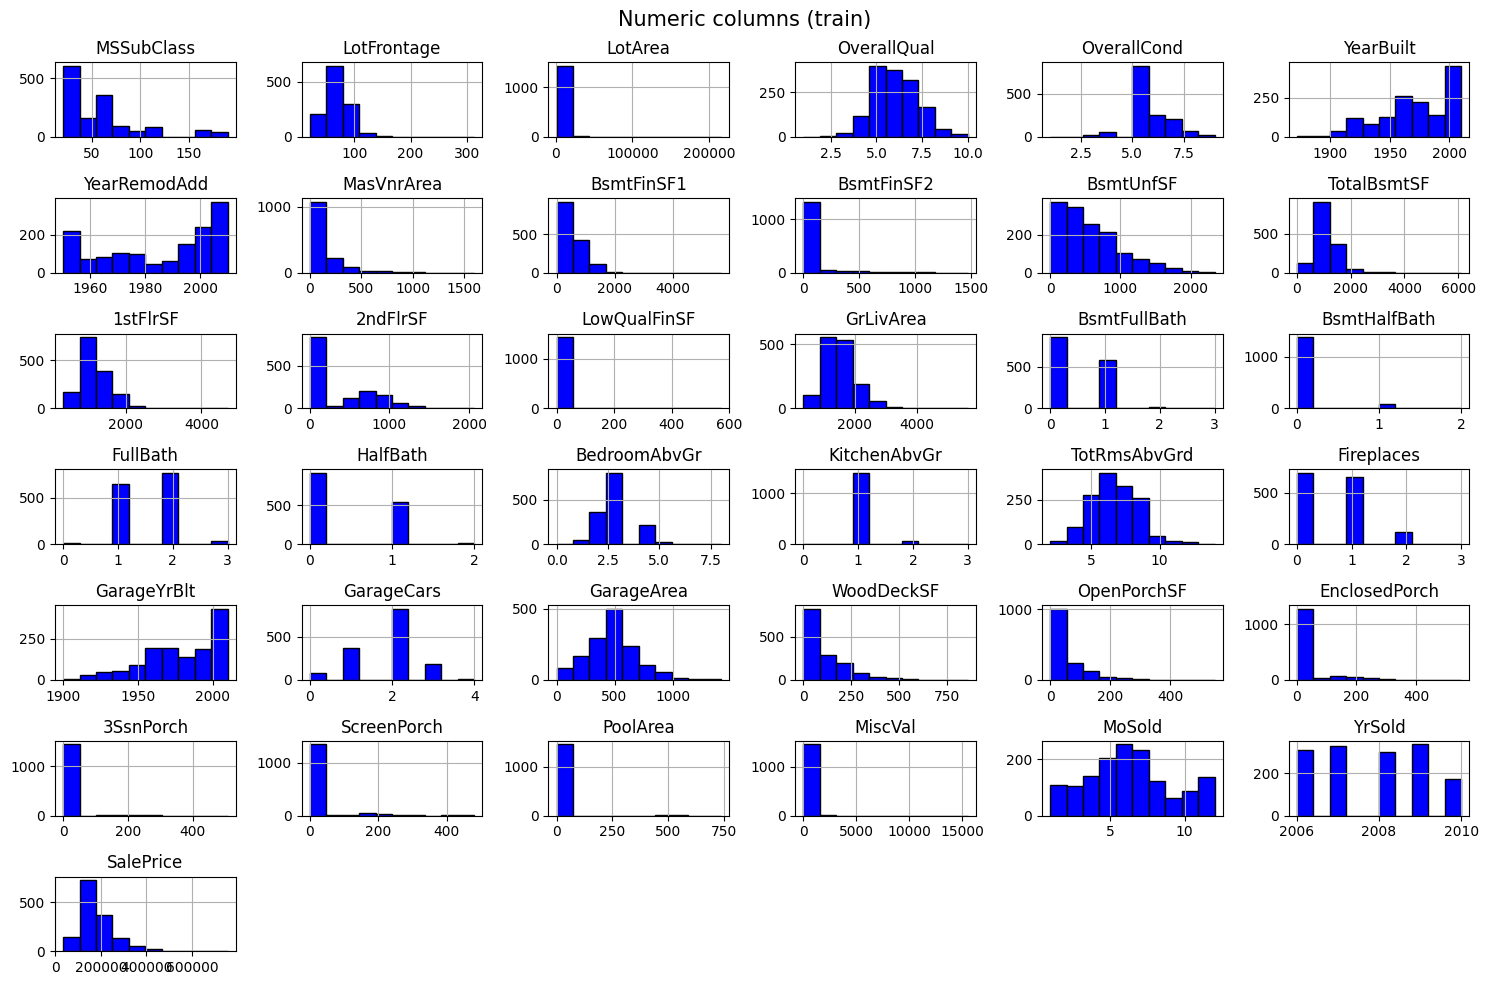

In [138]:
# Plot histograms of numeric columns
cols_to_display = train_df.columns[1:]
train_df[cols_to_display].hist(
    figsize=(15, 10), color="blue", edgecolor="black")
plt.suptitle("Numeric columns (train)", fontsize=15)
plt.tight_layout()
plt.show()

# Data preprocessing

### Encoding Categorical Features

In [139]:
label_encoder = LabelEncoder()

In [140]:
def encoding(data):
    categories = data.select_dtypes("object").columns
    for i in categories:
        data[i]=label_encoder.fit_transform(data[i])

In [141]:
# Apply encoding to both training and testing data
encoding (train_df)
encoding (test_df)

### Handling Missing Values

In [142]:
# Check and display the number of missing values in each column
train_df.isnull().sum().sort_values(ascending=False)

LotFrontage     259
GarageYrBlt      81
MasVnrArea        8
Id                0
KitchenAbvGr      0
               ... 
ExterQual         0
MasVnrType        0
Exterior2nd       0
Exterior1st       0
SalePrice         0
Length: 81, dtype: int64

In [143]:
test_df.isnull().sum().sort_values(ascending=False)

LotFrontage      227
GarageYrBlt       78
MasVnrArea        15
BsmtFullBath       2
BsmtHalfBath       2
                ... 
MasVnrType         0
Exterior2nd        0
Exterior1st        0
RoofMatl           0
SaleCondition      0
Length: 80, dtype: int64

In [144]:
# Function to impute missing values with column means
def impute(data):
    numerical_features = data.select_dtypes(include=['number'])
    df_filled = data[numerical_features.columns].fillna(data[numerical_features.columns].mean(), inplace=True)
    return df_filled

In [145]:
# Apply imputation to both training and testing data
impute(train_df)
impute(test_df)

### Feature Scaling

In [146]:
def scale_features(train_df, test_df):
    scaler = StandardScaler()
    
    # Exclude the 'Id' and 'SalePrice' columns from scaling in both datasets
    numerical_features_train = train_df.iloc[:, 1:-1].select_dtypes(include=['number'])
    numerical_features_test = test_df.iloc[:, 1:].select_dtypes(include=['number'])
    
    # Standardize the numeric features in the training dataset
    train_df[train_df.columns[1:-1]] = scaler.fit_transform(numerical_features_train)
    
    # Standardize the numeric features in the testing dataset
    test_df[test_df.columns[1:]] = scaler.transform(numerical_features_test)

In [147]:
# Apply feature scaling to both training and testing data
scale_features(train_df, test_df)

# Model Initialization and Training

In [148]:
# Initialize the XGBoost regression model
xgb_model = XGBRegressor(
    n_estimators=100,       # Number of boosting rounds
    learning_rate=0.1,      # Step size shrinkage to prevent overfitting
    max_depth=3,            # Maximum depth of trees
    random_state=42         # Seed for reproducibility
)

In [149]:
# Separate target variable from features
X_train = train_df.drop('SalePrice', axis=1)
y_train = train_df['SalePrice']
X_test = test_df

In [150]:
# Train the XGBoost model on the training data
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

# Making Predictions

In [151]:
# Make predictions on the testing data
y_pred = xgb_model.predict(X_test)

In [152]:
# Generate Output DataFrame
output = pd.DataFrame(
    data={
        'Id': test_df['Id'],
        'SalePrice': y_pred
    }
)
output.sample(15, random_state=42)

,Id,SalePrice
1321,2782,93701.648438
836,2297,310917.750000
413,1874,147553.375000
522,1983,210850.609375
1035,2496,244665.640625
614,2075,150227.875000
218,1679,403564.093750
1031,2492,178825.593750
1289,2750,145503.125000
886,2347,194782.843750


In [153]:
# Saving the DataFrame as a csv-file
output.to_csv('submission.csv', index=False)

# Displaying a success message
print("The submission has been successfully saved.")

The submission has been successfully saved.
